In [1]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings

# NOTE: I am ignoring the deprecation warnings on lmafit because I haven't found a way around them yet
warnings.filterwarnings("ignore")

cwd = os.getcwd()
par = os.path.join(cwd, os.pardir)
sys.path.append(par)

# I made some modules to make importing easier and to have a nice class
# that does all the matrix operations
from matrix_operation import mat_opr
from Dataset import dataset

### Import and combine NYT and Big10

In [2]:
# hopefully this works on with your directory structure
# dset.nyt_df : NYT data
# dset.big10_df : Big10 data
# dset.combined and dset.dataframe are the combined version
dset = dataset()

# drop all zero rows
dset.drop_zero_rows()
dset.drop_zero_cols()

### Check the SVD to see whats going on with the rank:

In [3]:
np.linalg.matrix_rank(dset.array)

27

104 singular values (the matrix is 104 x 1872)


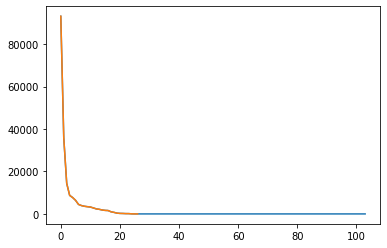

In [4]:
u, s, vt  = np.linalg.svd(dset.array)
print(str(s.shape[0]) + " singular values (the matrix is 104 x 1872)")
plt.plot(range(len(s)),s)

# The first 28 values are the only ones that aren't tiny numbers -- effective rank of 28?

plt.plot(range(27),s[:27])

#print(s[:28])

### Calculate rank approximation 

In [5]:
denom = 0
for i in s:
    denom += i**2

numer = 0
ratio = 0
ranker = 0
while ratio < 0.8:
    ratio = (numer + s[ranker]**2)/denom
    ranker += 1
    
print("rank approx: " + str(ranker))

rank approx: 1


## Compare inputs and output after lmafit + isotonic regression

In [6]:
inp = dset.dataframe

# Matrix completion
X,Y,oth = dset.lmafitter(rank = ranker, val = 0)
comp = pd.DataFrame(np.dot(X,Y))

pre_iso = comp
pre_iso.columns = inp.columns
pre_iso.index = inp.index

# Isotonic regression
comp = mat_opr(comp)
iso = comp.iso()

out = iso.dataframe
out.columns = inp.columns
out.index = inp.index

### Big 10 Schools

<AxesSubplot:title={'center':'University of Iowa'}>

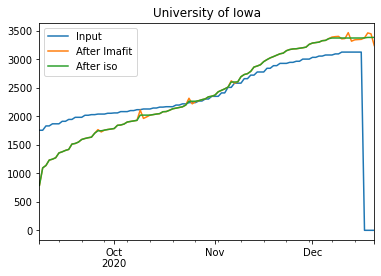

In [7]:
Iowa = pd.concat([inp['Iowa'], pre_iso['Iowa'], out['Iowa']], axis = 1)
Iowa.columns = ['Input', 'After lmafit', 'After iso']

Iowa.plot(legend=True, title = "University of Iowa")

<AxesSubplot:title={'center':'Michigan State'}>

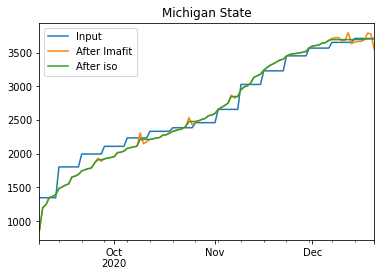

In [8]:
Michigan = pd.concat([inp['Michigan State'], pre_iso['Michigan State'], out['Michigan State']], axis = 1)
Michigan.columns = ['Input', 'After lmafit', 'After iso']

Michigan.plot(legend=True, title = "Michigan State")

<AxesSubplot:title={'center':'Ohio State'}>

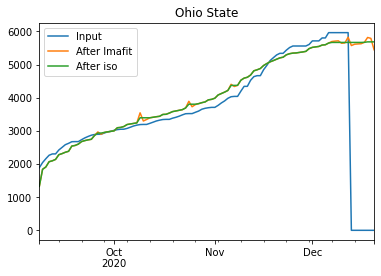

In [9]:
Ohio = pd.concat([inp['Ohio State'], pre_iso['Ohio State'], out['Ohio State']], axis = 1)
Ohio.columns = ['Input', 'After lmafit', 'After iso']

Ohio.plot(legend=True, title="Ohio State")

### NYT Schools

<AxesSubplot:title={'center':'Boston University'}>

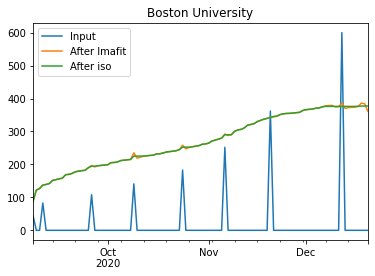

In [10]:
bu = pd.concat([inp['Boston University'], pre_iso['Boston University'], out['Boston University']], axis = 1)
bu.columns = ['Input', 'After lmafit', 'After iso']

bu.plot(legend=True, title = 'Boston University')

<AxesSubplot:title={'center':'University of California, Los Angeles'}>

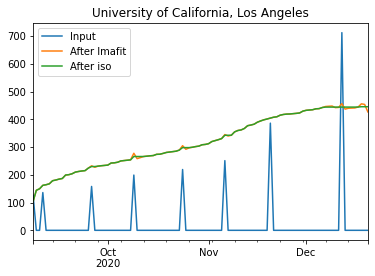

In [11]:
ucla = pd.concat([inp['University of California, Los Angeles'], pre_iso['University of California, Los Angeles'], out['University of California, Los Angeles']], axis = 1)
ucla.columns = ['Input', 'After lmafit', 'After iso']

ucla.plot(legend=True, title = 'University of California, Los Angeles')

<AxesSubplot:title={'center':'Florida State University'}>

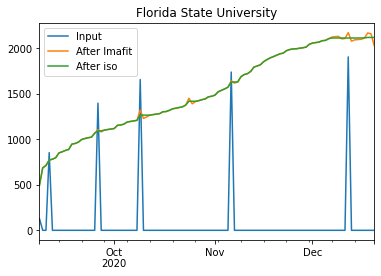

In [12]:
florida = pd.concat([inp['Florida State University'], pre_iso['Florida State University'], out['Florida State University']], axis = 1)
florida.columns = ['Input', 'After lmafit', 'After iso']

florida.plot(legend=True, title = 'Florida State University')

### Randomly Hide entries and compute error

In [13]:
def error(hidden_vals, newframe):
    # hidden_vals is a dictionary with structure {(x,y): value}
    # new frame is the dataframe after doing matrix completion etc.
    
    # Keeping things simple by doing mean absolute error for now
    summ = 0
    for h in hidden_vals.keys():
        frame_val = newframe.iloc[h[0],h[1]]
        err = abs(frame_val - hidden_vals[h])
        summ += err
        
    mean_absolute = summ/len(hidden_vals)
    
    #print("The computed matrix has an average error of " + str(mean_absolute))
    #print()
    return mean_absolute
        
        

In [14]:
def hider(obj, trials = [], isotonic = False):
    # trials should be a list of percents [0.33, 0.25, ...] corresponding to how much data is hidden
    trials.sort()
    
    results = []
    for i in trials:
        # Make the new hidden matrix and record the values that were hidden
        hidden_matrix, hidden_values = obj.hide_entries(i, 0)
        
        # Do lmafit
        X,Y,other = hidden_matrix.lmafitter(rank = ranker, val = 0)
        complete = pd.DataFrame(np.dot(X,Y))
        
        #print("With " + str(i) + " percent hidden: ")
        #hidden_matrix.is_col_inc()
        
        # Optional: do isotonic regression
        if isotonic == True:
            iso_reg = mat_opr(complete).iso()
            results.append(error(hidden_values, iso_reg.dataframe))
        else:
            results.append(error(hidden_values, complete))
            
    return results
        

In [15]:
tests = np.linspace(0.1,1,10)

{0.1: 58.21745393014961, 0.2: 59.822237430817474, 0.30000000000000004: 60.93578767759851, 0.4: 61.878562199919166, 0.5: 67.01499013700735, 0.6: 73.08846438514632, 0.7000000000000001: 83.35543881251968, 0.8: 118.01918262088854, 0.9: 186.62004094789359, 1.0: 400.9449286111626}


Text(0.5, 1.0, 'Error after matrix completion')

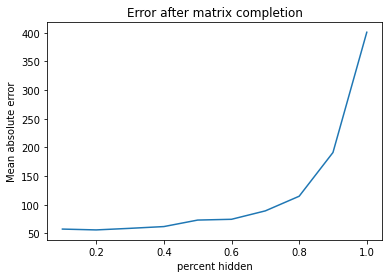

In [16]:
# These tests take a while
final_err = [0 for i in range(len(tests))]

# average over 5 trials
for i in range(5):
    errors = hider(dset, tests)
    for j in range(len(errors)):
        final_err[j] += errors[j]
    
final_err = [i/5 for i in final_err]
print({tests[i]:final_err[i] for i in range(len(tests))})
    
    
plt.plot(tests, errors)
plt.xlabel("percent hidden")
plt.ylabel("Mean absolute error")
plt.title("Error after matrix completion")

{0.1: 57.35930620950255, 0.2: 58.75738966970631, 0.30000000000000004: 56.64085779398582, 0.4: 60.80514891475931, 0.5: 65.22672796020221, 0.6: 67.98031782111154, 0.7000000000000001: 78.9577299963359, 0.8: 102.66481220043313, 0.9: 178.417467627673, 1.0: 400.9449286111626}


Text(0.5, 1.0, 'Error after matrix completion + isotonic regression')

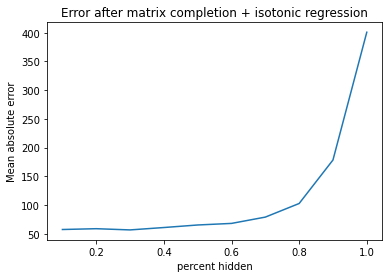

In [17]:
# with isotonic regression:
final_err = [0 for i in range(len(tests))]

# average over 5 trials
for i in range(5):
    errors = hider(dset, tests, True)
    for j in range(len(errors)):
        final_err[j] += errors[j]
    
final_err = [i/5 for i in final_err]
print({tests[i]:final_err[i] for i in range(len(tests))})

plt.plot(tests, final_err)
plt.xlabel("percent hidden")
plt.ylabel("Mean absolute error")
plt.title("Error after matrix completion + isotonic regression")